In [4]:
# numpy and pandas for data manipulation
import sys
import os
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import cPickle as pickle

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/'
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/collaborative-optimizer'
root_data = ROOT + '/data'

sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment
from experiment_graph.executor import CollaborativeExecutor
from experiment_graph.workload import Workload


DATABASE_PATH = root_data + '/experiment_graphs/home-credit-default-risk/materialized-no-groupby'
N_ESTIMATOR = 100
from experiment_graph.optimizations.Reuse import LinearTimeReuse
reuse_type=LinearTimeReuse.NAME

In [5]:
#!/usr/bin/env python

"""Optimized workload ID = 1

This script is the optimized version of the baseline workload 'start_here_a_gentle_introduction' (ID = 1)
which utilizes our Experiment Graph for optimizing the workload

Original notebook is located here:
    https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Number of artifacts: 397
Total artifact size: 14.5 GB
"""
import os
import sys
import warnings
# matplotlib and seaborn for plotting
from datetime import datetime

import matplotlib


SOURCE_CODE_ROOT = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/collaborative' \
                       '-optimizer/ '
sys.path.append(SOURCE_CODE_ROOT)

matplotlib.use('ps')

import matplotlib.pyplot as plt
import numpy as np
# numpy and pandas for data manipulation
import pandas as pd
import seaborn as sns

# Experiment Graph

# Suppress warnings
warnings.filterwarnings('ignore')


class start_here_a_gentle_introduction(Workload):

    def run(self, execution_environment, root_data, verbose=0):
        print(os.listdir(root_data))
        app_train = execution_environment.load(root_data + '/kaggle_home_credit/application_train.csv')
        print('Training data shape: ', app_train.shape().data(verbose))
        app_train.head().data(verbose)

        app_test = execution_environment.load(root_data + '/kaggle_home_credit/application_test.csv')
        print('Testing data shape: ', app_test.shape().data(verbose))
        app_test.head().data(verbose)

        test_labels = execution_environment.load(root_data + '/kaggle_home_credit/application_test_labels.csv')

        app_train['TARGET'].value_counts().data(verbose)

        app_train['TARGET'].data(verbose).astype(int).plot.hist()

        # Function to calculate missing values by column# Funct
        def missing_values_table(dataset):
            # Total missing values
            mis_val = dataset.isnull().sum().data(verbose)

            mis_val_percent = 100 * mis_val / len(dataset.data(verbose))

            # Make a table with the results
            mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
            # Rename the columns
            mis_val_table_ren_columns = mis_val_table.rename(columns={
                0: 'Missing Values',
                1: '% of Total Values'
            })
            # Sort the table by percentage of missing descending
            mis_val_table_ren_columns = mis_val_table_ren_columns[
                mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
                '% of Total Values', ascending=False).round(1)

            # Print some summary information
            print("Your selected dataframe has " + str(dataset.shape().data(verbose)[1]) + " columns.\n"
                                                                                           "There are " + str(
                mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")

            # Return the dataframe with missing information
            return mis_val_table_ren_columns

        missing_values = missing_values_table(app_train)
        missing_values.head(20)

        app_train.dtypes().data(verbose).value_counts()

        app_train.select_dtypes('object').nunique().data(verbose)

        from experiment_graph.sklearn_helper.preprocessing import LabelEncoder
        # Create a label encoder object
        le_count = 0

        columns = app_train.select_dtypes('object').data(verbose).columns
        for col in columns:
            # we are not using nunique because it discard nan
            if app_train[col].nunique(dropna=False).data(verbose) <= 2:
                le = LabelEncoder()
                le.fit(app_train[col])

                app_train = app_train.replace_columns(col, le.transform(app_train[col]))
                app_test = app_test.replace_columns(col, le.transform(app_test[col]))

                # Keep track of how many columns were label encoded
                le_count += 1
        print('%d columns were label encoded.' % le_count)
        app_train.data(verbose)
        app_test.data(verbose)

        app_train = app_train.onehot_encode()
        app_test = app_test.onehot_encode()

        print('Training Features shape: ', app_train.shape().data(verbose))
        print('Testing Features shape: ', app_test.shape().data(verbose))

        train_labels = app_train['TARGET']
        app_train = app_train.align(app_test)
        app_test = app_test.align(app_train)

        app_train = app_train.add_columns('TARGET', train_labels)

        print('Training Features shape: ', app_train.shape().data(verbose))
        print('Testing Features shape: ', app_test.shape().data(verbose))

        (app_train['DAYS_BIRTH'] / 365).describe().data(verbose)

        app_train['DAYS_EMPLOYED'].describe().data(verbose)

        app_train['DAYS_EMPLOYED'].data(verbose).plot.hist(title='Days Employment Histogram')
        plt.xlabel('Days Employment')

        anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
        non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
        print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean().data(verbose)))
        print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean().data(verbose)))
        print('There are %d anomalous days of employment' % anom.shape().data(verbose)[0])

        days_employed_anom = app_train["DAYS_EMPLOYED"] == 365243
        app_train = app_train.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
        temp = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})
        app_train = app_train.drop('DAYS_EMPLOYED')
        app_train = app_train.add_columns('DAYS_EMPLOYED', temp)

        app_train["DAYS_EMPLOYED"].data(verbose).plot.hist(title='Days Employment Histogram');
        plt.xlabel('Days Employment')

        days_employed_anom = app_test["DAYS_EMPLOYED"] == 365243
        app_test = app_test.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
        temp = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})
        app_test = app_test.drop('DAYS_EMPLOYED')
        app_test = app_test.add_columns('DAYS_EMPLOYED', temp)
        print('There are %d anomalies in the test data out of %d entries'
              % (app_test['DAYS_EMPLOYED_ANOM'].sum().data(verbose),
                 app_test.shape().data(verbose)[0]))

        correlations = app_train.corr().data(verbose)
        top = correlations['TARGET'].sort_values()
        # Display correlations
        print('Most Positive Correlations:\n', top.tail(15))
        print('\nMost Negative Correlations:\n', top.head(15))

        abs_age = app_train['DAYS_BIRTH'].abs()
        app_train = app_train.drop('DAYS_BIRTH')
        app_train = app_train.add_columns('DAYS_BIRTH', abs_age)
        app_train['DAYS_BIRTH'].corr(app_train['TARGET']).data(verbose)

        # Set the style of plots
        plt.style.use('fivethirtyeight')

        # Plot the distribution of ages in years
        plt.hist((app_train['DAYS_BIRTH'] / 365).data(verbose), edgecolor='k', bins=25)
        plt.title('Age of Client')
        plt.xlabel('Age (years)')
        plt.ylabel('Count')

        plt.figure(figsize=(10, 8))
        # KDE plot of loans that were repaid on time
        sns.kdeplot((app_train[app_train['TARGET'] == 0]['DAYS_BIRTH'] / 365).data(verbose), label='target == 0')
        # KDE plot of loans which were not repaid on time
        sns.kdeplot((app_train[app_train['TARGET'] == 1]['DAYS_BIRTH'] / 365).data(verbose), label='target == 1')
        # Labeling of plot
        plt.xlabel('Age (years)')
        plt.ylabel('Density')
        plt.title('Distribution of Ages')

        # Age information into a separate dataframe
        age_data = app_train[['TARGET', 'DAYS_BIRTH']]
        years_birth = age_data['DAYS_BIRTH'] / 365
        age_data = age_data.add_columns('YEARS_BIRTH', years_birth)
        binned = age_data['YEARS_BIRTH'].binning(20, 70, 11)
        binned.setname('YEARS_BINNED')
        age_data = age_data.add_columns('YEARS_BINNED', binned)
        age_data.head(10).data(verbose)

        age_groups = age_data.groupby('YEARS_BINNED').mean()
        age_groups.data(verbose)

        plt.figure(figsize=(8, 8))

        # Graph the age bins and the average of the target as a bar plot
        plt.bar(age_groups.data(verbose).index.astype(str), age_groups.data(verbose)['TARGET'] * 100)

        # Plot labeling
        plt.xticks(rotation=75)
        plt.xlabel('Age Group (years)')
        plt.ylabel('Failure to Repay (%)')
        plt.title('Failure to Repay by Age Group')

        ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
        ext_data_corrs = ext_data.corr().data(verbose)

        plt.figure(figsize=(8, 6))

        # Heatmap of correlations
        sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
        plt.title('Correlation Heatmap')

        plt.figure(figsize=(10, 12))

        # iterate through the sources
        for i, column in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
            # create a new subplot for each source
            plt.subplot(3, 1, i + 1)
            # plot repaid loans
            source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 0]
            sns.kdeplot(source_data[app_train[column].notna()][column].data(verbose), label='target == 0')
            # plot loans that were not repaid
            source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 1]
            sns.kdeplot(source_data[app_train[column].notna()][column].data(verbose), label='target == 1')

            # Label the plots
            plt.title('Distribution of %s by Target Value' % column)
            plt.xlabel('%s' % column)
            plt.ylabel('Density')

        plt.tight_layout(h_pad=2.5)

        # Copy the data for plotting
        plot_data = ext_data.drop('DAYS_BIRTH')

        # Add in the age of the client in years
        plot_data = plot_data.add_columns('YEARS_BIRTH', age_data['YEARS_BIRTH'])
        # Drop na values and limit to first 100000 rows
        plot_data = plot_data.head(100000).dropna()

        # Create the pair grid object
        grid = sns.PairGrid(data=plot_data.data(verbose), size=3, diag_sharey=False,
                            hue='TARGET',
                            vars=[x for x in list(plot_data.data(verbose).columns) if x != 'TARGET'])

        # Upper is a scatter plot
        grid.map_upper(plt.scatter, alpha=0.2)

        # Diagonal is a histogram
        grid.map_diag(sns.kdeplot)

        # Bottom is density plot
        grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

        plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

        # Make a new dataframe for polynomial features
        poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
        poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

        # imputer for handling missing values
        from experiment_graph.sklearn_helper.preprocessing import Imputer

        imputer = Imputer(strategy='median')

        poly_target = poly_features['TARGET']

        poly_features = poly_features.drop(columns=['TARGET'])

        # Need to impute missing values
        poly_features = imputer.fit_transform(poly_features)
        poly_features_test = imputer.transform(poly_features_test)

        from experiment_graph.sklearn_helper.preprocessing import PolynomialFeatures

        # Create the polynomial object with specified degree
        poly_transformer = PolynomialFeatures(degree=3)

        # Train the polynomial features
        poly_transformer.fit(poly_features)

        # Transform the features
        poly_features = poly_transformer.transform(poly_features)
        poly_features_test = poly_transformer.transform(poly_features_test)
        print('Polynomial Features shape: ', poly_features.shape().data(verbose))

        new_names = poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                       'EXT_SOURCE_3', 'DAYS_BIRTH'])

        poly_features = poly_features.set_columns(new_names)

        # Add in the target
        poly_features = poly_features.add_columns('TARGET', poly_target)

        # Find the correlations with the target
        poly_corrs = poly_features.corr().data(verbose)['TARGET'].sort_values()

        # Display most negative and most positive
        print(poly_corrs.head(10))
        print(poly_corrs.tail(5))

        poly_features_test = poly_features_test.set_columns(new_names)

        # Merge polynomial features into training dataframe
        poly_features = poly_features.add_columns('SK_ID_CURR', app_train['SK_ID_CURR'])
        app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

        # Merge polnomial features into testing dataframe
        poly_features_test = poly_features_test.add_columns('SK_ID_CURR', app_test['SK_ID_CURR'])
        app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

        # Align the dataframes
        app_train_poly = app_train_poly.align(app_test_poly)
        app_test_poly = app_test_poly.align(app_train_poly)

        # Print out the new shapes
        print('Training data with polynomial features shape: ',
              app_train_poly.shape().data(verbose))
        print('Testing data with polynomial features shape:  ',
              app_test_poly.shape().data(verbose))

        app_train_domain = app_train.copy()
        app_test_domain = app_test.copy()

        app_train_domain = app_train_domain.add_columns('CREDIT_INCOME_PERCENT',
                                                        app_train_domain['AMT_CREDIT'] / app_train_domain[
                                                            'AMT_INCOME_TOTAL'])
        app_train_domain = app_train_domain.add_columns('ANNUITY_INCOME_PERCENT',
                                                        app_train_domain['AMT_ANNUITY'] / app_train_domain[
                                                            'AMT_INCOME_TOTAL'])
        app_train_domain = app_train_domain.add_columns('CREDIT_TERM',
                                                        app_train_domain['AMT_ANNUITY'] / app_train_domain[
                                                            'AMT_CREDIT'])
        app_train_domain = app_train_domain.add_columns('DAYS_EMPLOYED_PERCENT',
                                                        app_train_domain['DAYS_EMPLOYED'] / app_train_domain[
                                                            'DAYS_BIRTH'])

        app_test_domain = app_test_domain.add_columns('CREDIT_INCOME_PERCENT',
                                                      app_test_domain['AMT_CREDIT'] / app_test_domain[
                                                          'AMT_INCOME_TOTAL'])
        app_test_domain = app_test_domain.add_columns('ANNUITY_INCOME_PERCENT',
                                                      app_test_domain['AMT_ANNUITY'] / app_test_domain[
                                                          'AMT_INCOME_TOTAL'])
        app_test_domain = app_test_domain.add_columns('CREDIT_TERM',
                                                      app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT'])
        app_test_domain = app_test_domain.add_columns('DAYS_EMPLOYED_PERCENT',
                                                      app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'])

        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler

        # Drop the target from the training data
        columns = app_train.data(verbose).columns
        if 'TARGET' in columns:
            train = app_train.drop(columns=['TARGET'])
        else:
            train = app_train.copy()

        # Feature names
        features = list(train.data(verbose).columns)

        # Copy of the testing data
        test = app_test.copy()

        # Median imputation of missing values
        imputer = Imputer(strategy='median')

        # Scale each feature to 0-1
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Fit on the training data
        imputer.fit(train)

        # Transform both training and testing data
        train = imputer.transform(train)
        test = imputer.transform(test)

        # Repeat with the scaler
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        print('Training data shape: ', train.shape().data(verbose))
        print('Testing data shape: ', test.shape().data(verbose))

        from experiment_graph.sklearn_helper.linear_model import LogisticRegression

        # Make the model with the specified regularization parameter
        log_reg = LogisticRegression(C=0.0001)

        # Train on the training data
        log_reg.fit(train, train_labels)

        score = log_reg.score(test,
                              test_labels['TARGET'],
                              score_type='auc').data(verbose)
        print 'Logistic Regression with AUC score: {}'.format(score)

        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier

        # Make the random forest classifier
        random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

        # Train on the training data
        random_forest.fit(train, train_labels)

        # Extract feature importance
        feature_importances = random_forest.feature_importances(features)

        score = random_forest.score(test,
                                    test_labels['TARGET'],
                                    score_type='auc').data(verbose)
        print 'Random Forest Simple Data with AUC score: {}'.format(score)

        poly_features_names = list(app_train_poly.data(verbose).columns)

        # Impute the polynomial features
        imputer2 = Imputer(strategy='median')

        imputer2.fit(app_train_poly)

        app_train_poly = imputer2.transform(app_train_poly)
        app_test_poly = imputer2.transform(app_test_poly)

        # Scale the polynomial features
        scaler = MinMaxScaler(feature_range=(0, 1))

        app_train_poly = scaler.fit_transform(app_train_poly)
        app_test_poly = scaler.transform(app_test_poly)

        random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
        random_forest_poly.fit(app_train_poly, train_labels)

        score = random_forest_poly.score(app_test_poly,
                                         test_labels['TARGET'],
                                         score_type='auc').data(verbose)
        print 'Random Forest Poly Data with AUC score: {}'.format(score)

        app_train_domain = app_train_domain.drop(columns='TARGET')

        domain_features_names = list(app_train_domain.data(verbose).columns)

        # Impute the domainnomial features
        imputer = Imputer(strategy='median')

        domain_features = imputer.fit_transform(app_train_domain)
        domain_features_test = imputer.transform(app_test_domain)

        # Scale the domainnomial features
        scaler = MinMaxScaler(feature_range=(0, 1))

        domain_features = scaler.fit_transform(domain_features)
        domain_features_test = scaler.transform(domain_features_test)

        # Train on the training data
        random_forest_domain = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
        random_forest_domain.fit(domain_features, train_labels)

        # Extract feature importances
        feature_importances_domain = random_forest_domain.feature_importances(domain_features_names)

        score = random_forest_domain.score(domain_features_test,
                                           test_labels['TARGET'],
                                           score_type='auc').data(verbose)
        print 'Random Forest Domain Data with AUC score: {}'.format(score)

        def plot_feature_importances(df):
            """
            Plot importances returned by a model. This can work with any measure of
            feature importance provided that higher importance is better.

            Args:
                df (dataframe): feature importances. Must have the features in a column
                called `features` and the importances in a column called `importance

            Returns:
                shows a plot of the 15 most importance features

                df (dataframe): feature importances sorted by importance (highest to lowest)
                with a column for normalized importance
                """

            # Sort features according to importance
            df = df.sort_values('importance', ascending=False)

            # Normalize the feature importances to add up to one
            df = df.add_columns('importance_normalized', df['importance'] / df['importance'].sum().data(verbose))

            # Make a horizontal bar chart of feature importances
            plt.figure(figsize=(10, 6))
            ax = plt.subplot()

            # Need to reverse the index to plot most important on top
            ax.barh(list(reversed(list(df.data(verbose).index[:15]))),
                    df['importance_normalized'].data(verbose).head(15),
                    align='center', edgecolor='k')

            # Set the yticks and labels
            ax.set_yticks(list(reversed(list(df.data(verbose).index[:15]))))
            ax.set_yticklabels(df['feature'].data(verbose).head(15))

            # Plot labeling
            plt.xlabel('Normalized Importance')
            plt.title('Feature Importances')
            plt.show()

            return df

        # Show the feature importances for the default features
        feature_importances_sorted = plot_feature_importances(feature_importances)

        feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

        from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

        def model(lgb_featres, test_features, encoding='ohe'):

            """Train and test a light gradient boosting model using
            cross validation.

            Parameters
            --------
                features (pd.DataFrame):
                    dataframe of training features to use
                    for training a model. Must include the TARGET column.
                test_features (pd.DataFrame):
                    dataframe of testing features to use
                    for making predictions with the model.
                encoding (str, default = 'ohe'):
                    method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
                    n_folds (int, default = 5): number of folds to use for cross validation

            Return
            --------
                submission (pd.DataFrame):
                    dataframe with `SK_ID_CURR` and `TARGET` probabilities
                    predicted by the model.
                feature_importances (pd.DataFrame):
                    dataframe with the feature importances from the model.
                valid_metrics (pd.DataFrame):
                    dataframe with training and validation metrics (ROC AUC) for each fold and overall.

            """

            # Extract the ids
            train_ids = lgb_featres['SK_ID_CURR']
            test_ids = test_features['SK_ID_CURR']

            # Extract the labels for training
            labels = lgb_featres['TARGET']

            # Remove the ids and target
            lgb_featres = lgb_featres.drop(columns=['SK_ID_CURR', 'TARGET'])
            test_features = test_features.drop(columns=['SK_ID_CURR'])

            # One Hot Encoding
            if encoding == 'ohe':
                lgb_featres = lgb_featres.onehot_encode()
                test_features = test_features.onehot_encode()

                features_columns = lgb_featres.data(verbose).columns
                test_features_columns = test_features.data(verbose).columns
                for c in features_columns:
                    if c not in test_features_columns:
                        lgb_featres = lgb_featres.drop(c)

                # No categorical indices to record
                cat_indices = 'auto'

            # # Integer label encoding
            # elif encoding == 'le':
            #
            #     # Create a label encoder
            #     label_encoder = LabelEncoder()
            #
            #     # List for storing categorical indices
            #     cat_indices = []
            #
            #     # Iterate through each column
            #     for i, col in enumerate(lgb_featres):
            #         if lgb_featres[col].dtype == 'object':
            #             # Map the categorical features to integers
            #             lgb_featres[col] = label_encoder.fit_transform(np.array(lgb_featres[col].astype(str)).reshape((-1,)))
            #             test_features[col] = label_encoder.transform(
            #                 np.array(test_features[col].astype(str)).reshape((-1,)))
            #
            #             # Record the categorical indices
            #             cat_indices.append(i)

            # Catch error if label encoding scheme is not valid
            else:
                raise ValueError("Encoding must be either 'ohe' or 'le'")

            print('Training Data Shape: ', lgb_featres.shape().data(verbose))
            print('Testing Data Shape: ', test_features.shape().data(verbose))

            # Extract feature names
            feature_names = list(lgb_featres.data(verbose).columns)

            # Create the model
            model = LGBMClassifier(objective='binary',
                                   class_weight='balanced', learning_rate=0.05,
                                   reg_alpha=0.1, reg_lambda=0.1,
                                   subsample=0.8, n_jobs=-1, random_state=50)

            # Train the model
            model.fit(lgb_featres, labels, custom_args={'eval_metric': 'auc',
                                                        'categorical_feature': cat_indices,
                                                        'verbose': 200})

            # Record the best iteration
            best_iteration = model.best_iteration()

            # Make predictions
            score = model.score(test_features,
                                test_labels['TARGET'],
                                score_type='auc',
                                custom_args={'num_iteration': best_iteration}).data(verbose)
            print 'LGBMClassifier with AUC score: {}'.format(score)

            feature_importances = model.feature_importances(feature_names)

            return feature_importances

        fi = model(app_train, app_test)
        fi_sorted = plot_feature_importances(fi)

        app_train_domain = app_train_domain.add_columns('TARGET', train_labels)

        # Test the domain knowledge features
        fi_domain = model(app_train_domain, app_test_domain)
        fi_sorted = plot_feature_importances(fi_domain)

        return True





['kaggle_home_credit', '.DS_Store', 'optimized_app_train.csv', 'baseline_app_train.csv', 'profiles', 'openml', 'experiment_graphs']
creating a new root node
executing 1 steps to compute vertex 4A3F3862EC3739B17293F6C0469C4825
('Training data shape: ', (246008, 122))
executing 1 steps to compute vertex 51706642912947F8FE42884FC3D178EC
creating a new root node
executing 1 steps to compute vertex 86CFD76958926538A85C44814257E4D9
('Testing data shape: ', (61503, 121))
executing 1 steps to compute vertex AF81475B28FC81FF5FDA3450B04F83B8
creating a new root node
executing 2 steps to compute vertex 5F1A78DEF5005C37A39167096883035E
executing 2 steps to compute vertex D882E2920B99DDB0F79170CBE49FAFF2
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
executing 1 steps to compute vertex 8FE81BE1C6C355ED19FFB628AE6160DD
executing 2 steps to compute vertex B351F3B87011FBF5D50EE1C70EA15AF5
executing 2 steps to compute vertex A9D4A852BBDF071D0E5D7959776FB912
exec

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


executing 7 steps to compute vertex 95680220D6C8E72C87BC6E521C13C9C7
Random Forest Simple Data with AUC score: {'auc': 0.50686889903323951}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


executing 21 steps to compute vertex 0325D7A51B5A14246F5A28F83188893F
Random Forest Poly Data with AUC score: {'auc': 0.52899783365121555}
executing 34 steps to compute vertex 2C9ECE62FAC41B9C7BF1B144C72C2C79


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


executing 53 steps to compute vertex 2BFBC74636877189CBB1185426EE7520
Random Forest Domain Data with AUC score: {'auc': 0.52689879863247069}
executing 4 steps to compute vertex A1CF592C54C15AEE07EDD3F65C9B690F
executing 5 steps to compute vertex 1829D190B21DA8304EA654C1920685AD
executing 1 steps to compute vertex 86FFAF91FCC5D9D634100CB140D436FA
executing 1 steps to compute vertex 5F48ABD24A5ADF00655298112D741EEF


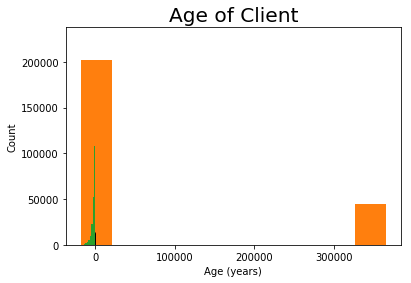

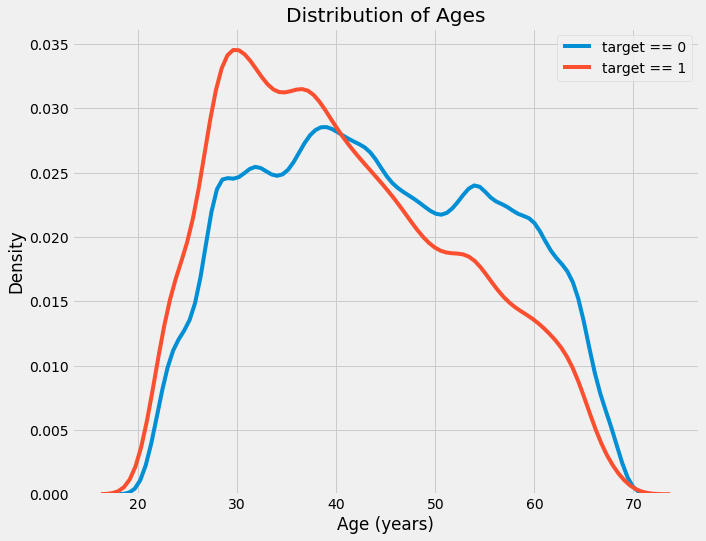

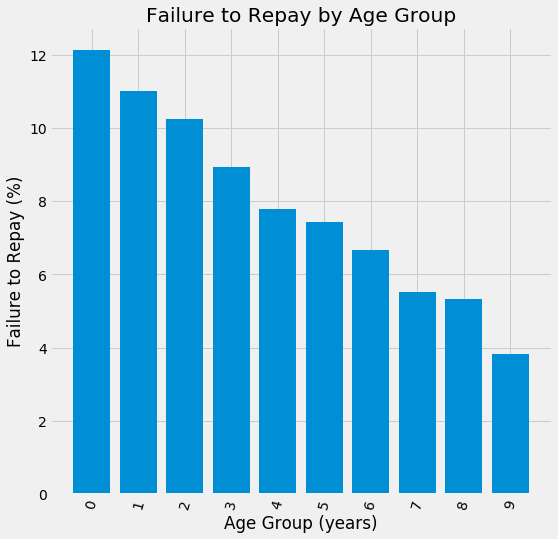

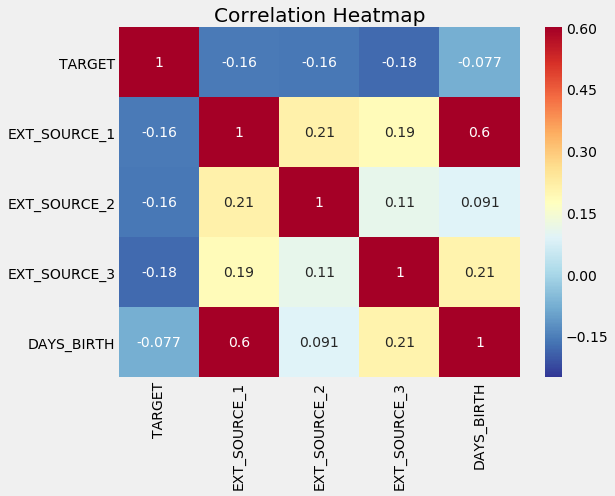

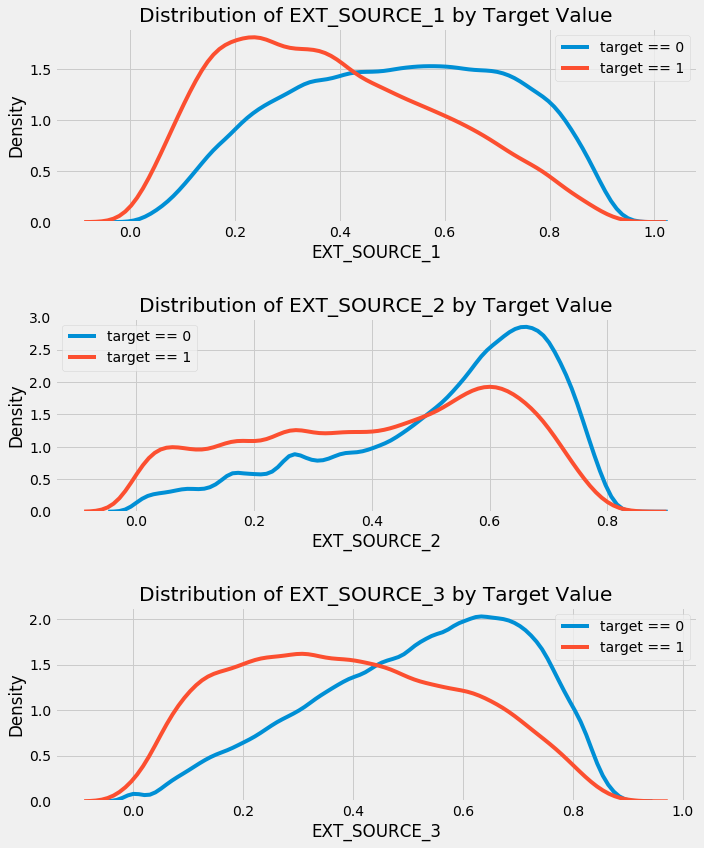

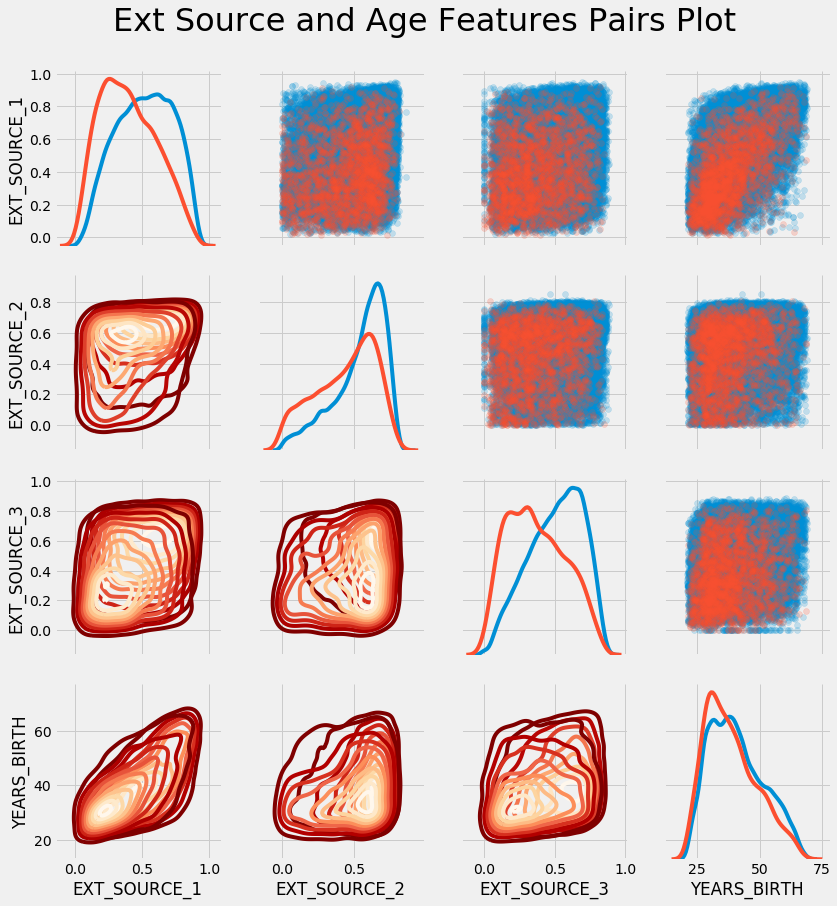

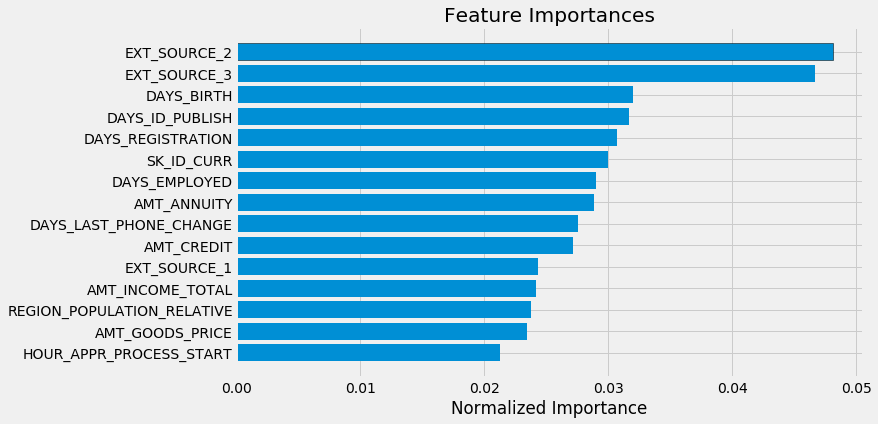

executing 4 steps to compute vertex CD68C9F078995CF1A0636FCA67C59F4A
executing 5 steps to compute vertex 22F226B7F4F5A13AFAE78E9AE54B1C48
executing 1 steps to compute vertex 817386DA6F105C3B9A66D9006660F459
executing 1 steps to compute vertex CDF2738F5C96E4082E696D1F29031F6B


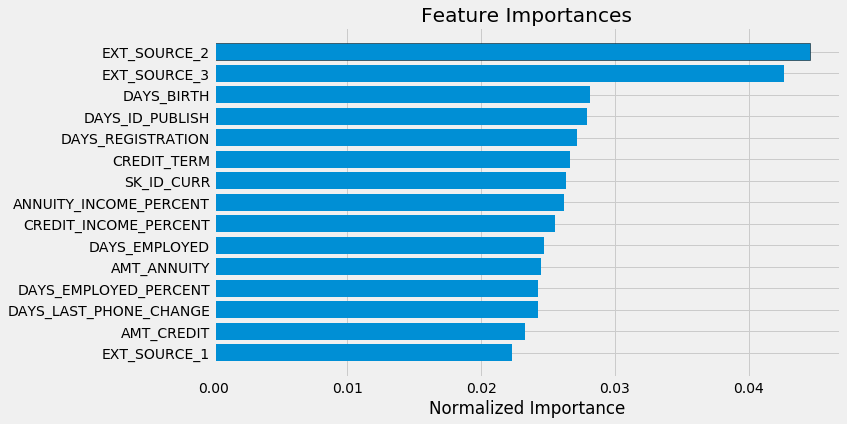

executing 2 steps to compute vertex F441125755257F133F56172404DE536C
executing 2 steps to compute vertex 50250F8744E3158DD67A6439757D3044
executing 1 steps to compute vertex 2723EEE18C65F3A6C5D24686A5DAFA1B
('Training Data Shape: ', (246008, 242))
executing 1 steps to compute vertex 7A8158352EB30442914FA5A137506BFE
('Testing Data Shape: ', (61503, 242))
executing 4 steps to compute vertex 833FA8D9400C4E2267FBBB29A6ED4F50
LGBMClassifier with AUC score: {'auc': 0.62740642946988112}
executing 4 steps to compute vertex 2CE3299A01551B309A57CCA2148AFF3F
executing 5 steps to compute vertex CB6D7AB5A6383FB2A966B134C3FCEB02
executing 1 steps to compute vertex DF415B77416C800879BF7E9BA0A1A97F
executing 1 steps to compute vertex 9587F98B29931FD1560D4D0CAD78EF9D


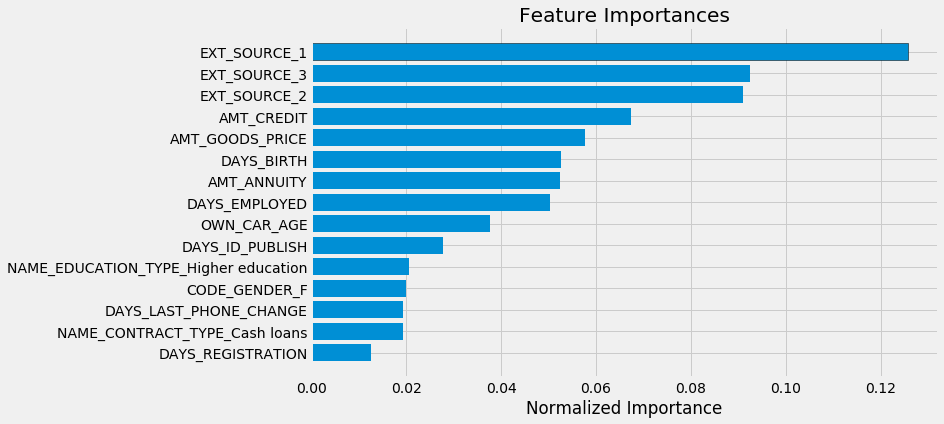

executing 5 steps to compute vertex E40A90A49AF3FECDBB50143A9DFD716B
executing 2 steps to compute vertex 03162C786E0C24AE7818FD209D4C691F
executing 1 steps to compute vertex C3252BE7C1DE49A1E1DC6856E3E9C6DD
('Training Data Shape: ', (246008, 246))
executing 1 steps to compute vertex C7BA7121BE4460923FAEFF955DE52079
('Testing Data Shape: ', (61503, 246))
executing 4 steps to compute vertex 331681BDCFB851117055065392100D51
LGBMClassifier with AUC score: {'auc': 0.62983905432040155}
executing 4 steps to compute vertex 46B0EF2369201D2792BA67E9904E6286
executing 5 steps to compute vertex 78C9200471FE1781EDB92A20E1C3B6F7
executing 1 steps to compute vertex 6F07051AEEFD6F713DBC6033A328BCB6
executing 1 steps to compute vertex DACA6475A5198A853302C67DC3CF7BE7


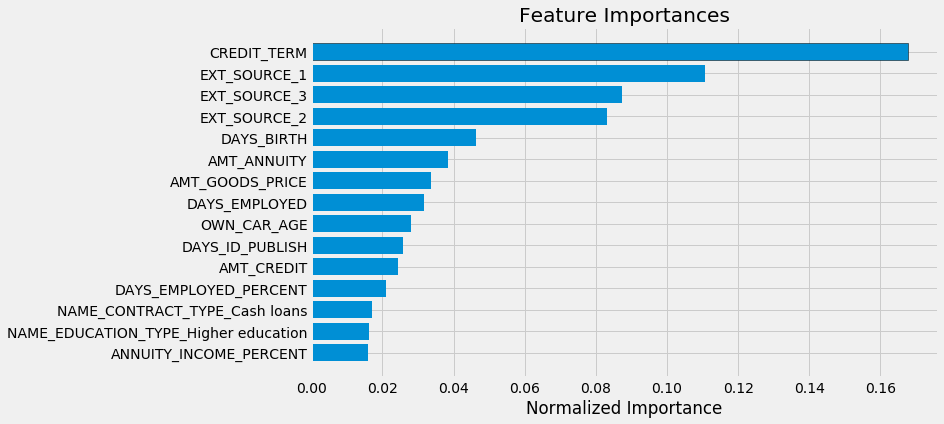

NameError: name 'database_path' is not defined

In [6]:
import sys

if len(sys.argv) > 1:
    SOURCE_CODE_ROOT = sys.argv[1]
else:
    SOURCE_CODE_ROOT = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/collaborative' \
                       '-optimizer/ '
sys.path.append(SOURCE_CODE_ROOT)
from paper.experiment_helper import Parser
from experiment_graph.data_storage import StorageManagerFactory
from experiment_graph.executor import CollaborativeExecutor
from experiment_graph.execution_environment import ExecutionEnvironment
from experiment_graph.storage_managers import storage_profiler

from experiment_graph.materialization_algorithms.materialization_methods import AllMaterializer, \
    StorageAwareMaterializer, HeuristicsMaterializer, HelixMaterializer

parser = Parser(sys.argv)
verbose = parser.get('verbose', 0)
DEFAULT_ROOT = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization'
ROOT = parser.get('root', DEFAULT_ROOT)
ROOT_DATA_DIRECTORY = ROOT + '/data'
mat_budget = float(parser.get('mat_budget', '10.0')) * 1024.0 * 1024.0
materializer_type = parser.get('materializer', 'helix')
storage_type = parser.get('storage_type', 'dedup')
if materializer_type == 'storage_aware':
    materializer = StorageAwareMaterializer(storage_budget=mat_budget)
elif materializer_type == 'simple':
    materializer = HeuristicsMaterializer(storage_budget=mat_budget)
elif materializer_type == 'all':
    materializer = AllMaterializer()
elif materializer_type == 'helix':
    materializer = HelixMaterializer(storage_budget=mat_budget)
else:
    raise Exception('invalid materializer: {}'.format(materializer_type))

storage_manager = StorageManagerFactory.get_storage(parser.get('storage_type', 'dedup'))
profile = storage_profiler.get_profile(parser.get('profile', ROOT_DATA_DIRECTORY + '/profiles/local-dedup'))
workload = start_here_a_gentle_introduction()

ee = ExecutionEnvironment(storage_manager, reuse_type='linear')
ROOT_DATA_DIRECTORY = ROOT + '/data'
if parser.has('experiment_graph'):

    database_path = parser.get('experiment_graph')
    if os.path.exists(database_path):
        print('loading experiment graph from {}'.format(database_path))
        ee.load_history_from_disk(database_path)
    else:
        print('experiment graph is not created yet: {}'.format(database_path))

executor = CollaborativeExecutor(ee, materializer=materializer)
execution_start = datetime.now()

executor.end_to_end_run(workload=workload, root_data=ROOT_DATA_DIRECTORY, verbose=1)
if parser.get('update_graph', 'yes').lower() == 'yes':
    executor.store_experiment_graph(database_path, overwrite=True)

execution_end = datetime.now()
elapsed = (execution_end - execution_start).total_seconds()

print('finished execution in {} seconds'.format(elapsed))


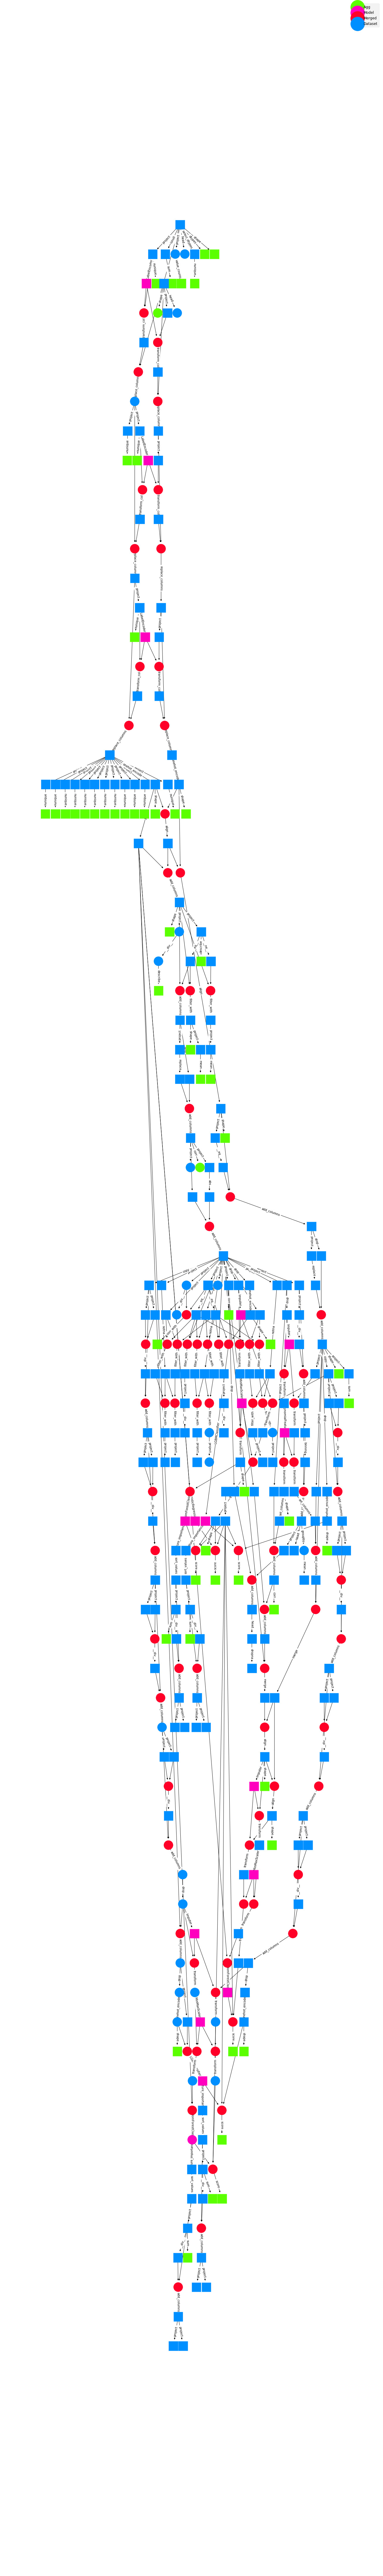

In [41]:
plot_graph(executor.execution_environment.experiment_graph,plt, figsize=(20,150),labels_for_vertex=[])
plt.savefig('workload_1_graph.pdf', bbox_inches='tight')

In [27]:

def summarize(node_type):
    if node_type == 'SK_Model':
        return 'Model'
    if node_type in ['Feature', 'Dataset', 'GroupBy']:
        return 'Dataset'
    if node_type in ['Agg', 'Evaluation']:
        return 'Agg'
    if node_type == 'SuperNode':
        return 'Merged'

In [40]:
def plot_graph(self, plt, figsize=(12, 12), labels_for_vertex=['size'], labels_for_edges=['name'], vertex_size=1000,
               vertex_font_size=10):
    """
    plot the graph using the graphvix dot layout
    :param vertex_font_size:
    :param vertex_size:
    :param labels_for_edges:
    :param labels_for_vertex:
    :param figsize: size of the figure (default (12,12))
    :param plt: matlibplot object
    """
    from networkx.drawing.nx_agraph import graphviz_layout
    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(1, 1, 1)
    pos = graphviz_layout(self.graph, prog='dot', args='')

    # get the list of available types and frequency of each node
    vertex_labels = {}
    unique_types = []

    for node in self.graph.nodes(data=True):
        s_type = summarize(node[1]['type'])
        if s_type not in unique_types:
            unique_types.append(s_type)
        labels = []
        for p in labels_for_vertex:

            if p == 'id':
                if node[1]['root']:
                    labels.append('root')
                else:
                    labels.append(node[0][:10])
            if p not in node[1]:
                labels.append('-')
            elif type(node[1][p]) is np.float64 or type(node[1][p]) is float:
                labels.append('{:.3f}'.format(node[1][p]))
            else:
                labels.append(str(node[1][p]))

        vertex_labels[node[0]] = ','.join(labels)

    jet = plt.get_cmap('gist_rainbow')
    colors = jet(np.linspace(0, 1, len(unique_types)))
    color_map = dict(zip(unique_types, colors))
    for label in color_map:
        ax.scatter(None, None, color=color_map[label], label=label)

    # TODO there's a problem with nodelist=...., the node type and legends dont match
    materialized_nodes = [n[0] for n in self.graph.node(data='mat') if n[1]]
    all_colors = [color_map[summarize(n[1]['type'])] for n in self.graph.nodes(data=True) if n[1]['mat']]
    nx.draw_networkx(
        self.graph,
        node_size=vertex_size,
        nodelist=materialized_nodes,
        cmap=jet,
        # vmin=0,
        # vmax=len(unique_types),
        node_color=all_colors,
        node_shape='s',
        pos=pos,
        with_labels=False,
        ax=ax)

    non_materialized_nodes = [n[0] for n in self.graph.node(data='mat') if not n[1]]
    all_colors = [color_map[summarize(n[1]['type'])] for n in self.graph.nodes(data=True) if not n[1]['mat']]
    nx.draw_networkx(
        self.graph,
        edgelist=[],
        node_size=vertex_size,
        nodelist=non_materialized_nodes,
        cmap=jet,
        # vmin=0,
        # vmax=len(unique_types),
        node_color=all_colors,
        node_shape='o',
        pos=pos,
        with_labels=False,
        ax=ax)

    if labels_for_vertex:
        nx.draw_networkx_labels(self.graph,
                                pos=pos,
                                labels=vertex_labels,
                                font_size=vertex_font_size)

    def construct_label(edge_data, edge_labels):
        return ','.join(['' if str(edge_data[l]) == 'combine' else str(edge_data[l]) for l in edge_labels])

    nx.draw_networkx_edge_labels(
        self.graph,
        pos=pos,
        edge_labels={(u, v): construct_label(d, labels_for_edges) for u, v, d in self.graph.edges(data=True)})

    plt.axis('off')
    f.set_facecolor('w')
    leg = ax.legend(markerscale=8, loc='best', fontsize=12, scatterpoints=1)

    for line in leg.get_lines():
        line.set_linewidth(4.0)